# 네이버 영화 리뷰 감성 분류
    
    IMDB 데이터와 유사한 데이터.
    데이터 : https://github.com/e9t/nsmc/

In [1]:
# 데이터 저장하기
import urllib.request

urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", 
                           filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", 
                           filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x10313ee20>)

In [9]:
import pandas as pd
train_data = pd.read_table("ratings_train.txt")
test_data = pd.read_table("ratings_test.txt")

print(f"train data size : {len(train_data)}")
print(f"test data size : {len(test_data)}")
train_data.head()

train data size : 150000
test data size : 50000


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 데이터 처리

### 1) 데이터 정제

In [10]:
# 중복 데이터 확인

print(train_data['document'].nunique())
print(train_data['label'].nunique())

146182
2


In [11]:
# train data 중복 제거

train_data.drop_duplicates(subset=['document'],inplace=True)
print(f"train data size : {len(train_data)}")

train data size : 146183


label
0    73342
1    72841
dtype: int64


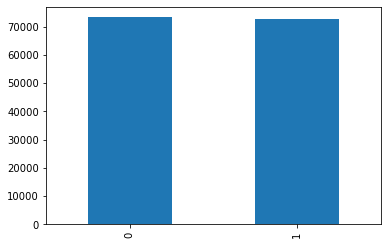

In [12]:
# label 분포 

train_data['label'].value_counts().plot(kind='bar')
print(train_data.groupby('label').size())

In [13]:
# NULL 값 확인

print(train_data.isnull().sum())
train_data.dropna(inplace=True)
print(train_data.isnull().sum())

id          0
document    1
label       0
dtype: int64
id          0
document    0
label       0
dtype: int64


In [14]:
# 한글과 공백 제외 제거.

train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

<ipython-input-14-cbeb800d58e8>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


In [15]:
train_data.head()

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


In [7]:
# 한글이 없는 리뷰인 경우 확인
import numpy as np

train_data['document'].replace('',np.nan,inplace=True)
print(train_data.isnull().sum())
train_data.dropna(inplace=True)
print(train_data.isnull().sum())

id            0
document    391
label         0
dtype: int64
id          0
document    0
label       0
dtype: int64


In [8]:
# test data 동일한 처리

test_data.drop_duplicates(subset=['document'],inplace=True) # 중복 데이터 확인.
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 한글과 공백 제외 제거
test_data['document'].replace("",np.nan,inplace=True) # 빈 데이터 제거
test_data.dropna(inplace=True)
print("test data size : ",len(test_data)) 

test data size :  48995


<ipython-input-8-7c7239abd4ee>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


### 2) 토큰화

In [9]:
# stopwords 는 책과 동일하게 진행

from konlpy.tag import Okt

stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로',
             '자','에','와','한','하다']

okt = Okt()

X_train = []
for sent in train_data['document'] :
    temp = []
    temp = okt.morphs(sent,stem=True)
    temp = [word for word in temp if word not in stopwords]
    X_train.append(temp)
    
print(X_train[:3])

[['아', '더빙', '진짜', '짜증나다', '목소리'], ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍다', '않다'], ['너', '무재', '밓었', '다그', '래서', '보다', '추천', '다']]


In [10]:
X_test = []
for sent in test_data['document'] :
    temp = []
    temp = okt.morphs(sent,stem=True)
    temp = [word for word in temp if word not in stopwords]
    X_test.append(temp)
print(X_test[:3])

[['굳다', 'ㅋ'], ['뭐', '야', '평점', '나쁘다', '않다', '점', '짜다', '리', '더', '더욱', '아니다'], ['지루하다', '않다', '완전', '막장', '임', '돈', '주다', '보기', '에는']]


### 3) 정수 인코딩

In [11]:
# threshold 확인

from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 43752
등장 빈도가 2번 이하인 희귀 단어의 수: 24337
단어 집합에서 희귀 단어의 비율: 55.62488571950996
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.8715872104872904


빈도수가 2%도 안되기 때문에 길이 2회 이하인 단어들은 무시.

In [12]:
# 0번 패딩 토큰 , 1번 OOV 토큰 고려 +2
vocab_size = total_cnt - rare_cnt + 2 
print(vocab_size)

19417


In [13]:
# 정수 인코딩
tokenizer = Tokenizer(num_words=vocab_size,oov_token='OOV')
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
print(X_train[:3])                    

[[51, 455, 17, 261, 660], [934, 458, 42, 603, 2, 215, 1450, 25, 962, 676, 20], [387, 2445, 1, 2316, 5672, 3, 223, 10]]


In [14]:
# 레이블 저장.
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

In [15]:
# 빈도수 낮은 단어 삭제 -> 빈 샘플 존재

drop_idx = [idx for idx, sent in enumerate(X_train) if len(sent) < 1]

X_train = np.delete(X_train,drop_idx,axis=0)
y_train = np.delete(y_train,drop_idx,axis=0)

print("X_train size : ",len(X_train))
print("y_train size : ",len(y_train))

X_train size :  145380
y_train size :  145380


### 4) 패딩

max length of reivews :  72
mean length of reivews :  11.002187371027652


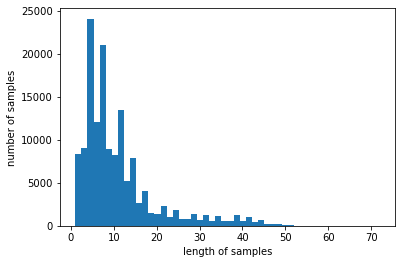

In [16]:
import matplotlib.pyplot as plt

max_len = max(len(word) for word in X_train)
mean_len = sum(map(len,X_train)) / len(X_train)
print("max length of reivews : ",max_len)
print("mean length of reivews : ",mean_len)

plt.hist([len(word) for word in X_train],bins=50)
plt.xlabel("length of samples")
plt.ylabel("number of samples")
plt.show()

## 4) 패딩
    최대 길이의 경우 집합의 길이를 보고 결정.

In [17]:
def belowThreshold(thre, words) :
    cnt = 0
    for word in words:
        if(len(word) <= thre) :
            cnt += 1
    print(f"percentage of sample that shorter threshold {thre} : {round((cnt / len(words)) * 100,3)}")
    
print("threshold : 30")
belowThreshold(30,X_train)
print("threshold : 40")
belowThreshold(40,X_train)

threshold : 30
percentage of sample that shorter threshold 30 : 94.083
threshold : 40
percentage of sample that shorter threshold 40 : 98.085


In [18]:
# 최대 길이 40으로 맞춤
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len = 40
X_train = pad_sequences(X_train,maxlen = max_len)
X_test = pad_sequences(X_test,maxlen = max_len)

## 2. LSTM 모델 사용

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Embedding,Dense

model = Sequential()
model.add(Embedding(vocab_size,100))
model.add(LSTM(128))
model.add(Dense(1,activation='sigmoid'))

In [22]:
# 조기 종료 요건과 베스트 모델 저장
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

es = EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=4)

mc = ModelCheckpoint('KOR_LSTM.h5',monitor='val_acc',mode='max',verbose=1,
                    save_best_only=True)

In [23]:
model.compile(optimizer='rmsprop',loss='binary_crossentropy',
              metrics=['acc'])

model.fit(X_train,y_train,epochs=15,callbacks=[es,mc],
          batch_size=60,validation_split=0.2)


Epoch 1/15
1939/1939 [==============================] - 213s 107ms/step - loss: 0.4378 - acc: 0.7920 - val_loss: 0.3512 - val_acc: 0.8452

Epoch 00001: val_acc improved from -inf to 0.84523, saving model to KOR_LSTM.h5
Epoch 2/15
1939/1939 [==============================] - 208s 107ms/step - loss: 0.3248 - acc: 0.8588 - val_loss: 0.3414 - val_acc: 0.8539

Epoch 00002: val_acc improved from 0.84523 to 0.85387, saving model to KOR_LSTM.h5
Epoch 3/15
1939/1939 [==============================] - 207s 107ms/step - loss: 0.2990 - acc: 0.8733 - val_loss: 0.3296 - val_acc: 0.8589

Epoch 00003: val_acc improved from 0.85387 to 0.85885, saving model to KOR_LSTM.h5
Epoch 4/15
1939/1939 [==============================] - 207s 107ms/step - loss: 0.2784 - acc: 0.8843 - val_loss: 0.3280 - val_acc: 0.8614

Epoch 00004: val_acc improved from 0.85885 to 0.86140, saving model to KOR_LSTM.h5
Epoch 5/15
1939/1939 [==============================] - 206s 106ms/step - loss: 0.2619 - acc: 0.8923 - val_loss: 0.

In [19]:
from tensorflow.keras.models import load_model

loaded_model = load_model('KOR_LSTM.h5')
print("test accuracy : ",loaded_model.evaluate(X_test,y_test)[1])

1532/1532 [==============================] - 5s 3ms/step - loss: 0.3406 - acc: 0.8521
test accuracy :  0.8521073460578918


In [20]:
def sent_predict(sent) :
    sent = okt.morphs(sent,stem=True)
    sent = [word for word in sent if word not in stopwords]
    encoded = tokenizer.texts_to_sequences([sent])
    padded = pad_sequences(encoded,maxlen=max_len)
    score = float(loaded_model.predict(padded))
    if(score > 0.5) :
        print(f"{round(score*100,3)} % Positive")
    else :
        print(f"{round((1-score)*100,3)} % Negative")


In [23]:
sent_predict("이 영화 개꿀잼 ㅋㅋ")

85.94 % Positive


In [24]:
sent_predict("이런걸 영화라고 만들었냐 ㅉㅉ")

96.851 % Negative
